#Test Distributions

For this study we need a set of test distributions that cover a variaty of different shapes. We chose the following distributions...

1. Flat Distribution (Flat)
2. Single Gaussian (Blob)
3. Six Gaussians (Blob6)
4. Bi-Maxwellian (BiMax)
5. TRANSP Distribution (TRANSP)

Each test distribution is normalized such that the integral over E-p space is equal to $1 \times 10^{12}$ fast-ions/cm³

In [3]:
using PyPlot
include("src/netcdf.jl")

energy = linspace(0.5,99.5,100);
dE = abs(energy[2]-energy[1]);
pitch = linspace(-0.99,.99,100);
dP = abs(pitch[2]-pitch[1]);
E = ones(100)*energy';
P = pitch*ones(100)';

##Flat Distribution

A flat distribution will allow us to see how the noise in the spectrum affects the reconstructions and it will also allow to see the effects of the weight functions. 

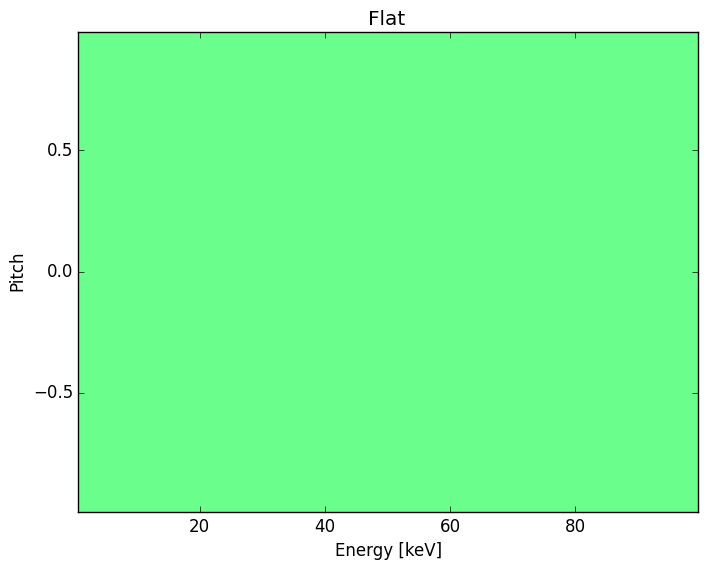

PyObject <matplotlib.text.Text object at 0xdc78c50>

In [6]:
flat = fill(1.0e12/(100*100*dE*dP),100,100);

fig,ax  = plt.subplots()
p = ax[:contourf](E,P,flat,30)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Flat")

##Single Gaussian

This distribution allows us to see if the algorithms can reconstruct a simple distribution

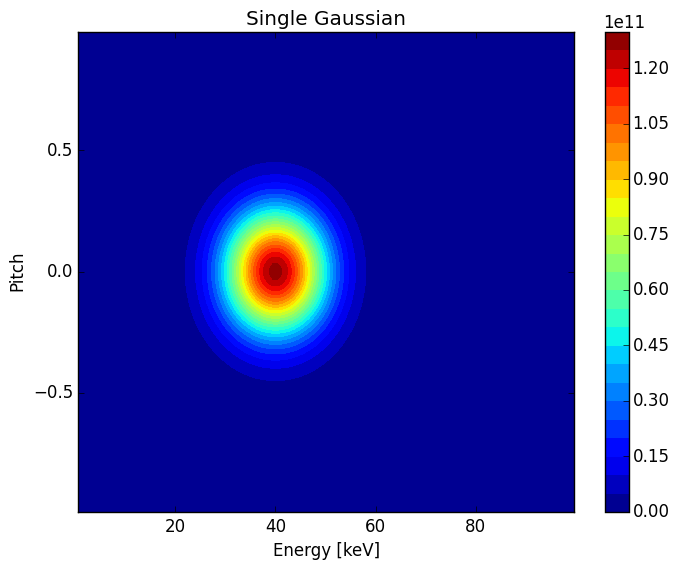

PyObject <matplotlib.colorbar.Colorbar instance at 0xe3fac68>

In [7]:
blob1 = exp(-(((E-40.0)/10.0).^2 + ((P/0.25).^2) ))
blob1 *= (1e12)/(sum(blob1)*dE*dP)

fig,ax  = plt.subplots()
p = ax[:contourf](E,P,blob1,30)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Single Gaussian")
fig[:colorbar](p)

##Six Gaussians

This distirbution lets us see how the algorithms deal with many localized regions

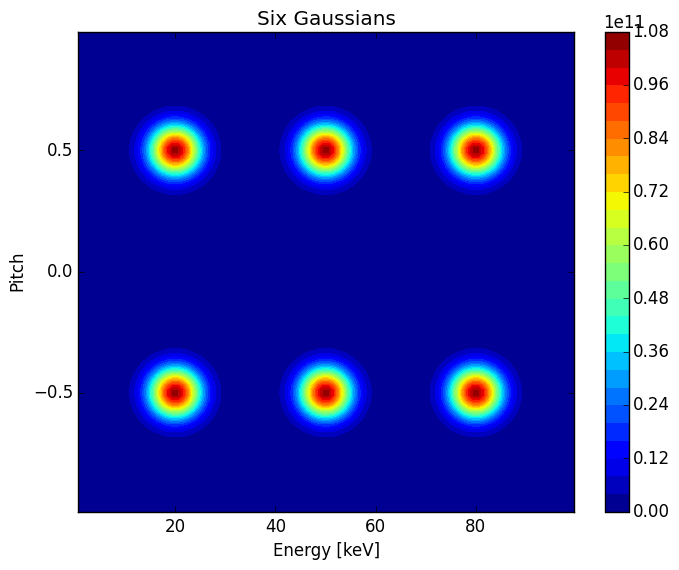

PyObject <matplotlib.colorbar.Colorbar instance at 0xe4a42d8>

In [8]:
blob6 = exp(-(((E-20.)/5.0).^2.0 + (((P-.5)/0.1).^2.0) ))
blob6 += exp(-(((E-50.)/5.0).^2.0 + (((P-.5)/0.1).^2.0) ))
blob6 += exp(-(((E-80.)/5.0).^2.0 + (((P-.5)/0.1).^2.0) ))
blob6 += exp(-(((E-20.)/5.0).^2.0 + (((P+.5)/0.1).^2.0) ))
blob6 += exp(-(((E-50.)/5.0).^2.0 + (((P+.5)/0.1).^2.0) ))
blob6 += exp(-(((E-80.)/5.0).^2.0 + (((P+.5)/0.1).^2.0) ))
blob6 *= (1e12)/(sum(blob6)*dE*dP)

fig,ax  = plt.subplots()
p = ax[:contourf](E,P,blob6,30)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Six Gaussians")
fig[:colorbar](p)

##Bi-Maxwellian

This is a common fast-ion distribution in RF heated plasmas. 

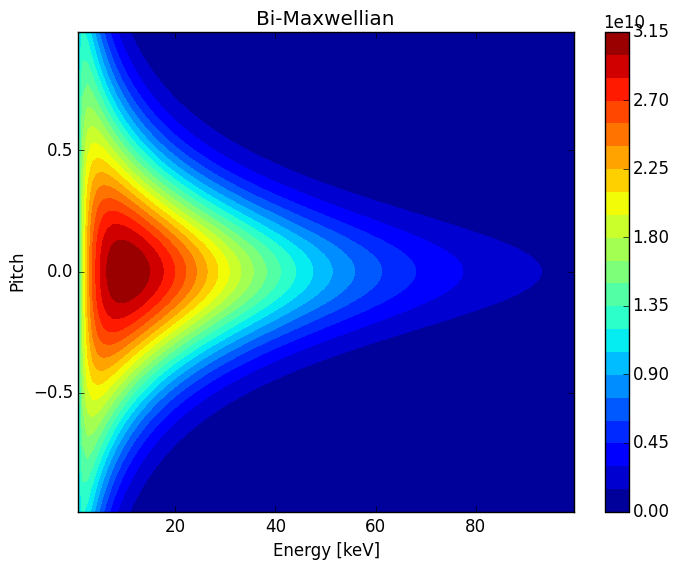

PyObject <matplotlib.colorbar.Colorbar instance at 0xe558128>

In [10]:
Epara = 3.0
Eperp = 20.0

bimax = ((1e12)/sqrt(pi))*(1.0/Eperp)*(1.0/sqrt(Epara))*sqrt(E).*exp(-(P.*P.*E/Epara)).*exp(-((1-P.*P).*E/Eperp))
bimax *= 1e12/(sum(bimax)*dE*dP)

fig,ax  = plt.subplots()
p = ax[:contourf](E,P,bimax,30)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Bi-Maxwellian")
fig[:colorbar](p)

##TRANSP

Like the Bi-Maxwellian this TRANSP distribution is representative of a typical beam heated plasma

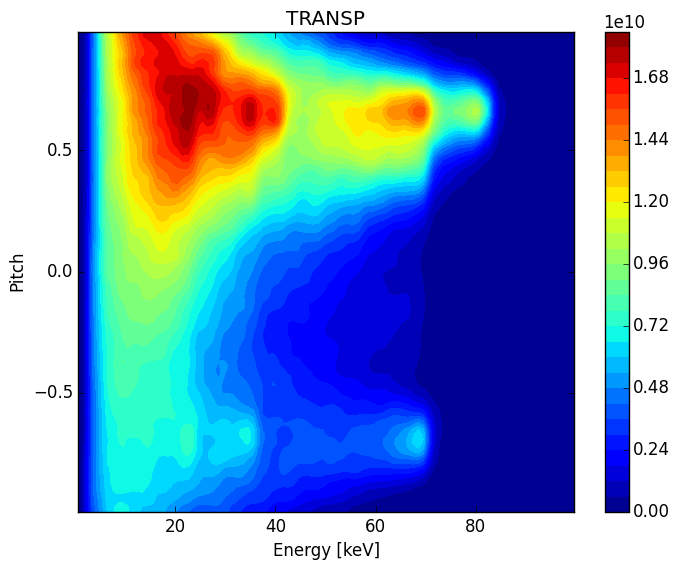

PyObject <matplotlib.colorbar.Colorbar instance at 0xe8e8518>

In [13]:
a = read_ncdf("data/d3d_transp.cdf")
transp = flipdim(a["MEAN_FBM"],2)' # need to put it in right layout
transp *= 1e12/(sum(transp)*dE*dP)
a=0; gc() #clear a variable

fig,ax  = plt.subplots()
p = ax[:contourf](E,P,transp,30)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("TRANSP")
fig[:colorbar](p)


##Save test distributions

In [14]:
using NetCDF

# Write transfer matrix to file
fname = "data/test_distributions.cdf"

isfile(fname) && rm(fname)

E_id = NcDim("ne",100)
P_id = NcDim("np",100)

flat_varid = NcVar("flat",[E_id,P_id])
blob1_varid = NcVar("blob",[E_id,P_id])
blob6_varid = NcVar("blob6",[E_id,P_id])
bimax_varid = NcVar("bimax",[E_id,P_id])
transp_varid = NcVar("transp",[E_id,P_id])
e_varid = NcVar("E",[E_id,P_id])
p_varid = NcVar("P",[E_id,P_id])

ncid = NetCDF.create(fname,[flat_varid,blob1_varid,blob6_varid,bimax_varid,transp_varid,e_varid,p_varid])

NetCDF.putvar(ncid,"flat",flat)
NetCDF.putvar(ncid,"blob",blob1)
NetCDF.putvar(ncid,"blob6",blob6)
NetCDF.putvar(ncid,"bimax",bimax)
NetCDF.putvar(ncid,"transp",transp)
NetCDF.putvar(ncid,"E",E)
NetCDF.putvar(ncid,"P",P)

NetCDF.close(ncid)

65536

#Synthetic Test Data

##Error Model
In experiments it is not possible to measure a single spectral component. The measured signal is comprised of active signal and background signal. To seperate out the active signal we have to have at least two measurements. A measurements of the active plus background signal and a background only signal. Subtracting the two signals will isolate the active signal.

The subtraction causes an interesting effect to the estimated error. When the active signal is large compared to the background the error primarely associated with the active signal. When the active signal is small compared the background the error is associated with the background signal. The error is also assumed to be gaussian-like. To generate test spectra from our test distributions we must be able to replicate this type of behavior. 

We propose the following model that has the correct behavior.

$$\sigma_A(\lambda) = \mathcal{A} * \max (\sqrt{A(\lambda)},\sqrt{B(\lambda)} ) * \mathcal{N}(0,1)$$

Where $\mathcal{A}$ is a scale factor. A convienient choice of $\mathcal{A}$ is $n*\mathrm{mean}(\sqrt{A(\lambda)})$. With this choice of $\mathcal{A}$, the factor $n$ can be thought of as the percentage of the mean value of $A$ which is useful for quantifying error levels.

In [15]:
function make_synthetic_data(A::Array{Float64,2},dist::Array{Float64,2},n::Float64,b::Float64; dE=1.0,dP = 0.02)
    y = (dE*dP) * (A*reshape(dist,length(dist)))
    
    scale = n*mean(sqrt(y))
    yerr = scale .* max(sqrt(y),sqrt(b)) .* randn(length(y))
    
    noisy_spectrum = y .+ yerr
    noisy_background = b .+ scale*sqrt(b).*randn(length(y))
    
    scale_est = n*mean(sqrt(abs(noisy_spectrum)))
    
    err = scale_est .* max(sqrt(abs(noisy_spectrum)),sqrt(abs(noisy_background)))
    
    return noisy_spectrum, err
end

make_synthetic_data (generic function with 1 method)

In [16]:
augd_t_mat = read_ncdf("data/augd_transfer_matrix.cdf","transfer_matrix");
d3d_t_mat  = read_ncdf("data/d3d_transfer_matrix.cdf","transfer_matrix");

###No Background
Error is dominatated by active signal causing an error profile that correlates with the signal profile.

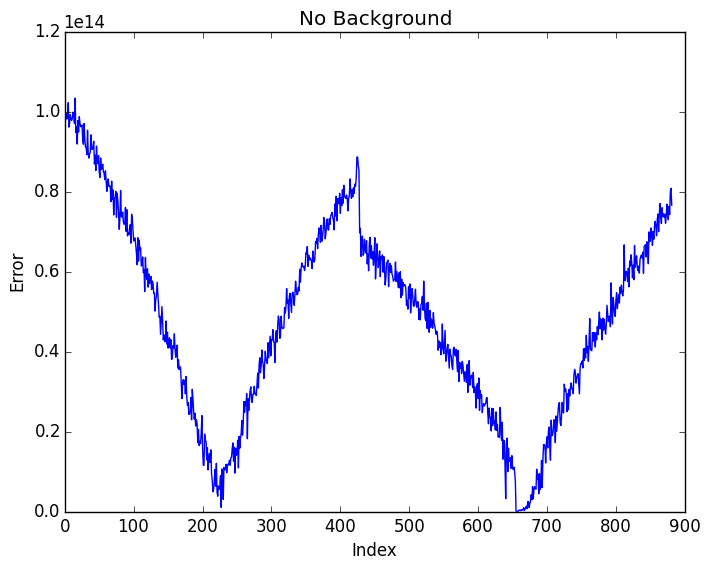

PyObject <matplotlib.text.Text object at 0xe90c710>

In [17]:
spec,err = make_synthetic_data(d3d_t_mat,flat,.1,0.0);
plot(err)
title("No Background")
xlabel("Index")
ylabel("Error")

###Typical Constant Background
This represents a typical experimental error profile where the background error dominates at relativively low active signal and active error dominates at relativively high active signal.

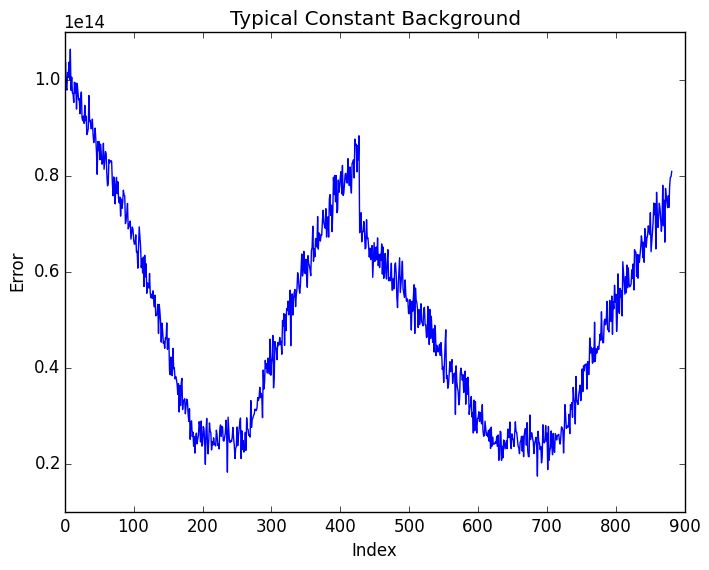

PyObject <matplotlib.text.Text object at 0xf03b810>

In [18]:
spec,err = make_synthetic_data(d3d_t_mat,flat,.1,1.25e14);
plot(err)
title("Typical Constant Background")
xlabel("Index")
ylabel("Error")

###High Constant Background
Error from background dominates causing a flat error profile

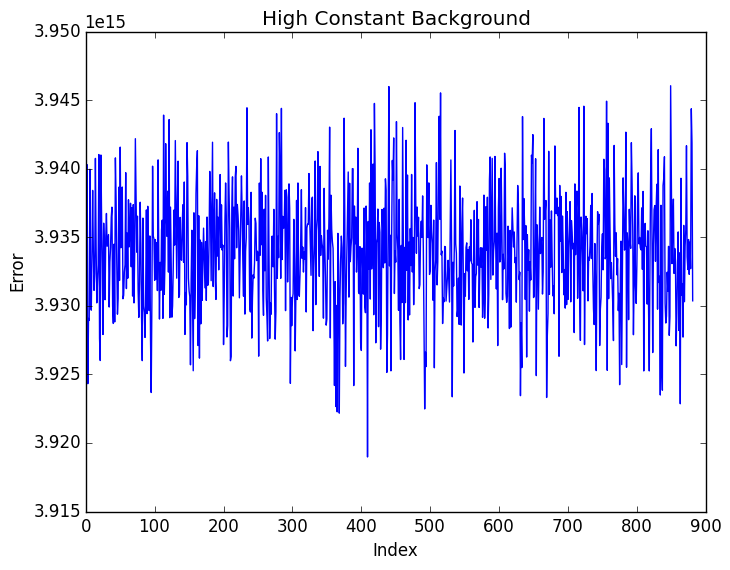

PyObject <matplotlib.text.Text object at 0xf098090>

In [19]:
spec,err = make_synthetic_data(d3d_t_mat,flat,.1,1e18);
plot(err)
title("High Constant Background")
xlabel("Index")
ylabel("Error")

##Generate Synthetic Test Data

###D3D Synthetic Test Data

In [20]:
# Get size of D3D transfer matrix
nrows,ncols = size(d3d_t_mat)

# Allocate storage
flat_spec = zeros(nrows,21)
flat_err = zeros(nrows,21)
blob_spec = zeros(nrows,21)
blob_err = zeros(nrows,21)
blob6_spec = zeros(nrows,21)
blob6_err = zeros(nrows,21)
bimax_spec = zeros(nrows,21)
bimax_err = zeros(nrows,21)
transp_spec = zeros(nrows,21)
transp_err = zeros(nrows,21)

# Generate synthetic data for varying error levels with the same background value
for (ind,n) in enumerate(0:.05:1)
    flat_spec[:,ind], flat_err[:,ind] = make_synthetic_data(d3d_t_mat,flat,n,1.25e14);
    blob_spec[:,ind], blob_err[:,ind] = make_synthetic_data(d3d_t_mat,blob1,n,1.25e14);
    blob6_spec[:,ind], blob6_err[:,ind] = make_synthetic_data(d3d_t_mat,blob6,n,1.25e14);
    bimax_spec[:,ind], bimax_err[:,ind] = make_synthetic_data(d3d_t_mat,bimax,n,1.25e14);
    transp_spec[:,ind], transp_err[:,ind] = make_synthetic_data(d3d_t_mat,transp,n,1.25e14);
end

In [21]:
using NetCDF
# Write synthetic data to file
fname = "data/d3d_test_data.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",nrows)
ncols_id = NcDim("ncols",21)

flat_spec_varid = NcVar("flat_spec",[nrows_id,ncols_id])
blob_spec_varid = NcVar("blob_spec",[nrows_id,ncols_id])
blob6_spec_varid = NcVar("blob6_spec",[nrows_id,ncols_id])
bimax_spec_varid = NcVar("bimax_spec",[nrows_id,ncols_id])
transp_spec_varid = NcVar("transp_spec",[nrows_id,ncols_id])

flat_err_varid = NcVar("flat_err",[nrows_id,ncols_id])
blob_err_varid = NcVar("blob_err",[nrows_id,ncols_id])
blob6_err_varid = NcVar("blob6_err",[nrows_id,ncols_id])
bimax_err_varid = NcVar("bimax_err",[nrows_id,ncols_id])
transp_err_varid = NcVar("transp_err",[nrows_id,ncols_id])

ncid = NetCDF.create(fname,[flat_spec_varid,blob_spec_varid,blob6_spec_varid,bimax_spec_varid,transp_spec_varid,
                            flat_err_varid,blob_err_varid,blob6_err_varid,bimax_err_varid,transp_err_varid])

NetCDF.putvar(ncid,"flat_spec",flat_spec)
NetCDF.putvar(ncid,"blob_spec",blob_spec)
NetCDF.putvar(ncid,"blob6_spec",blob6_spec)
NetCDF.putvar(ncid,"bimax_spec",bimax_spec)
NetCDF.putvar(ncid,"transp_spec",transp_spec)

NetCDF.putvar(ncid,"flat_err",flat_err)
NetCDF.putvar(ncid,"blob_err",blob_err)
NetCDF.putvar(ncid,"blob6_err",blob6_err)
NetCDF.putvar(ncid,"bimax_err",bimax_err)
NetCDF.putvar(ncid,"transp_err",transp_err)
NetCDF.close(ncid);

###AUGD Synthetic Test Data

In [22]:
# Get size of D3D transfer matrix
nrows,ncols = size(augd_t_mat)

# Allocate storage
flat_spec = zeros(nrows,21)
flat_err = zeros(nrows,21)
blob_spec = zeros(nrows,21)
blob_err = zeros(nrows,21)
blob6_spec = zeros(nrows,21)
blob6_err = zeros(nrows,21)
bimax_spec = zeros(nrows,21)
bimax_err = zeros(nrows,21)
transp_spec = zeros(nrows,21)
transp_err = zeros(nrows,21)

# Generate synthetic data for varying error levels with the same background value
for (ind,n) in enumerate(0:.05:1)
    flat_spec[:,ind], flat_err[:,ind] = make_synthetic_data(augd_t_mat,flat,n,1.25e14);
    blob_spec[:,ind], blob_err[:,ind] = make_synthetic_data(augd_t_mat,blob1,n,1.25e14);
    blob6_spec[:,ind], blob6_err[:,ind] = make_synthetic_data(augd_t_mat,blob6,n,1.25e14);
    bimax_spec[:,ind], bimax_err[:,ind] = make_synthetic_data(augd_t_mat,bimax,n,1.25e14);
    transp_spec[:,ind], transp_err[:,ind] = make_synthetic_data(augd_t_mat,transp,n,1.25e14);
end

In [23]:
using NetCDF
# Write synthetic data to file
fname = "data/augd_test_data.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",nrows)
ncols_id = NcDim("ncols",21)

flat_spec_varid = NcVar("flat_spec",[nrows_id,ncols_id])
blob_spec_varid = NcVar("blob_spec",[nrows_id,ncols_id])
blob6_spec_varid = NcVar("blob6_spec",[nrows_id,ncols_id])
bimax_spec_varid = NcVar("bimax_spec",[nrows_id,ncols_id])
transp_spec_varid = NcVar("transp_spec",[nrows_id,ncols_id])

flat_err_varid = NcVar("flat_err",[nrows_id,ncols_id])
blob_err_varid = NcVar("blob_err",[nrows_id,ncols_id])
blob6_err_varid = NcVar("blob6_err",[nrows_id,ncols_id])
bimax_err_varid = NcVar("bimax_err",[nrows_id,ncols_id])
transp_err_varid = NcVar("transp_err",[nrows_id,ncols_id])

ncid = NetCDF.create(fname,[flat_spec_varid,blob_spec_varid,blob6_spec_varid,bimax_spec_varid,transp_spec_varid,
                            flat_err_varid,blob_err_varid,blob6_err_varid,bimax_err_varid,transp_err_varid])

NetCDF.putvar(ncid,"flat_spec",flat_spec)
NetCDF.putvar(ncid,"blob_spec",blob_spec)
NetCDF.putvar(ncid,"blob6_spec",blob6_spec)
NetCDF.putvar(ncid,"bimax_spec",bimax_spec)
NetCDF.putvar(ncid,"transp_spec",transp_spec)

NetCDF.putvar(ncid,"flat_err",flat_err)
NetCDF.putvar(ncid,"blob_err",blob_err)
NetCDF.putvar(ncid,"blob6_err",blob6_err)
NetCDF.putvar(ncid,"bimax_err",bimax_err)
NetCDF.putvar(ncid,"transp_err",transp_err)
NetCDF.close(ncid);